In [2]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa
import torch
import json
from jiwer import wer, cer

## Load the model

In [4]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", torch_dtype=torch.float32)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare the data

In [6]:
def process_audio(file_path):
    audio, sr = librosa.load(file_path)
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    return input_values
# input_values["input_values"].dtype

## Data Visualization

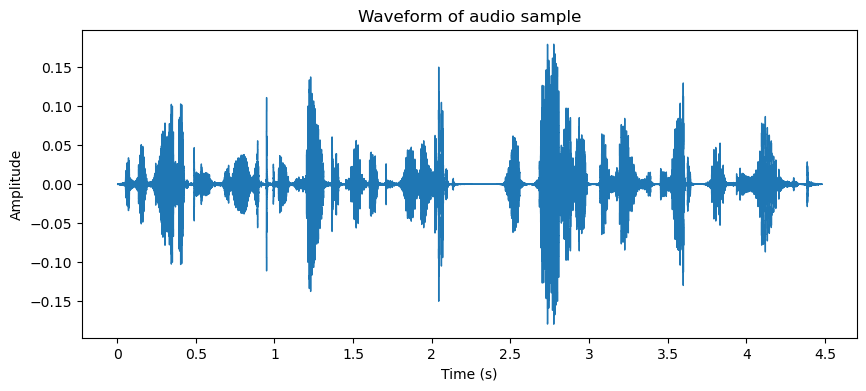

In [15]:
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

file_path = 'processed_audio/61-70968-0000.flac'

audio, sample_rate = librosa.load(file_path, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate)
plt.title(f"Waveform of audio sample")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [9]:
ipd.Audio(audio, rate=sample_rate)

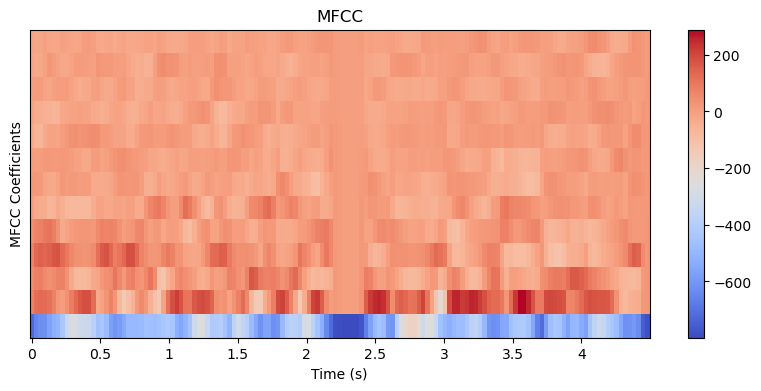

In [17]:
mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=16000, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

## Forward pass through the model

In [13]:
# Storing logits
input_values = process_audio(file_path)
with torch.no_grad():
    logits = model(**input_values).logits

## Decoding

In [15]:
# Storing predicted ids
predicted_ids = torch.argmax(logits, dim = -1)

# Decoding
predicted_transcription = processor.batch_decode(predicted_ids)[0]

# Print transcription
print(predicted_transcription)

HE BEGAN A CONFUSED COMPLAINT AGAINST THE WIZARD WHO HAD VANISHED BEHIND THE CURT ON THE LEFT


## Evaluation

In [17]:
actual_transcription = "HE BEGAN A CONFUSED COMPLAINT AGAINST THE WIZARD WHO HAD VANISHED BEHIND THE CURTAIN ON THE LEFT"
sample_cer = cer(actual_transcription.lower(), predicted_transcription.lower())
sample_wer = wer(actual_transcription.lower(), predicted_transcription.lower())
print(f'Sample CER: {sample_cer * 100:.4f}%')
print(f'Sample WER: {sample_wer * 100:.4f}%')

Sample CER: 3.1250%
Sample WER: 5.8824%


## Validation set

In [19]:
# Load the json into a dictionary
import json

mapping_file = "processed_audio/processed_audio_transcription_mapping.json"
with open(mapping_file, 'r') as f:
    audio_transcription_mapping = json.load(f)
print(f"Total number of cleaned audio-transcription pairs: {len(audio_transcription_mapping)}")

Total number of cleaned audio-transcription pairs: 2620


In [20]:
# Process test set
data_pairs = list(audio_transcription_mapping.items())[-500:]
# Get total length
total_predictions = len(data_pairs)
# Initialize results
correct_predictions = 0
cer_scores = []
wer_scores = []

for audio_path, actual_transcription in data_pairs:
    # Process audio
    input_values = process_audio(audio_path)

    # Storing logits
    with torch.no_grad():
        logits = model(**input_values).logits

    # Get prediction
    predicted_ids = torch.argmax(logits, dim = -1)
    predicted_transcription = processor.batch_decode(predicted_ids)[0]

    # Calc cer and wer
    cer_scores.append(cer(actual_transcription.lower(), predicted_transcription.lower()))
    wer_scores.append(wer(actual_transcription.lower(), predicted_transcription.lower()))

average_cer = sum(cer_scores) / len(cer_scores)
print(f'Average CER on the test set: {average_cer * 100:.4f}%')

average_wer = sum(wer_scores) / len(wer_scores)
print(f'Average WER on the test set: {average_wer * 100:.4f}%')

Average CER on the test set: 7.3664%
Average WER on the test set: 17.2815%
